<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session7/S7_AdvancedConcepts_Assignment7_AbhinavP_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn


In [2]:
!pip install albumentations==0.4.6
!pip install torchsummary

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 35.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=b951799d4b65f41e3261144f43f7bed005f170c0b500335dd0c98860541a757f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# EVA 7 Assignment 7 - Advanced Concepts

## Goals
1. Create a classification NN to train the CIFAR10 dataset to beyond 87% accuracy.
2. Network must have less than 100k parameters
3. One of the layers must use dilated convolution
4. 2 of the layers must use depthwise separable convolution
5. GAP must be used and mapped to the number of classes
6. Use Albumentation library to apply transformations
7. Code must be modular

## GPU Check

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## Specify Dataset Transformations & Download Dataset

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Calculate Dataset Statistics
def return_dataset_statistics():

  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train = True, download = True, transform = train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255

  return mean, std

mean, std = return_dataset_statistics()

## Train Phase transformations

def albumentation_augmentation():
  train_transforms = A.Compose([A.HorizontalFlip(p = 0.2),
                                A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 15, p = 0.25),
                                A.CoarseDropout(max_holes = 1, min_holes = 1, max_height = 16, max_width = 16, 
                                p = 0.5, fill_value = tuple([x * 255.0 for x in mean]),
                                min_height = 16, min_width = 16),
                                #A.ColorJitter(p = 0.25, brightness = 0.3, contrast = 0.3, saturation = 0.30, hue = 0.2),
                                A.ToGray(p = 0.15),
                                A.Normalize(mean = mean, std = std, always_apply = True),
                                ToTensorV2()
                              ])

  ## Test Phase transformations
  test_transforms = A.Compose([A.Normalize(mean = mean, std = std, always_apply = True),
                                ToTensorV2()])
  return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transforms, test_transforms = albumentation_augmentation()

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform = train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform = test_transforms)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Data Loader Specifications

In [25]:
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers=4, pin_memory = True) if cuda else dict(shuffle = True, batch_size=64)

trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualize Examples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  bird   cat   dog


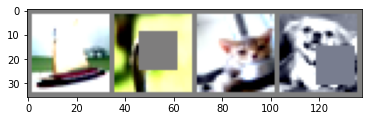

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define Model

In [7]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [34]:
## Model 4 - Additional Layers Added

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1A
        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 18, kernel_size = (3, 3), stride = 1, padding = 0, dilation = 2, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # CONVOLUTION BLOCK 2A
        self.convblock2a = nn.Sequential(
            nn.Conv2d(in_channels = 18, out_channels = 36, kernel_size = (3, 3), stride = 1, padding = 0, dilation = 2, bias = False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3A
        self.convblock3a = nn.Sequential(
            nn.Conv2d(in_channels = 36, out_channels = 72, kernel_size=(3, 3), stride = 2, padding = 0, dilation = 1, bias = False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(72),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # CONVOLUTION BLOCK 1B
        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 18, kernel_size = (5, 5), stride = 1, padding = 0, dilation = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # CONVOLUTION BLOCK 2B
        self.convblock2b = nn.Sequential(
            nn.Conv2d(in_channels = 18, out_channels = 36, kernel_size = (5, 5), stride = 1, padding = 0, dilation = 1, bias = False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # CONVOLUTION BLOCK 3B
        self.convblock3b = nn.Sequential(
            nn.Conv2d(in_channels = 36, out_channels = 72, kernel_size=(3, 3), stride = 2, padding = 0, dilation = 1, bias = False), ## Expand number of channels
            nn.ReLU(),
            nn.BatchNorm2d(72),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # TRANSITION BLOCK 1 - Pointwise convolution
        self.transblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 144, out_channels = 72, kernel_size=(1, 1), stride = 1, padding = 0, bias = False), ## Pointwise Convolution
            nn.ReLU(),
            nn.BatchNorm2d(72),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        ## CONVOLUTION BLOCK 4 - Depthwise Convolution
        self.depthwise_separable_block = nn.Sequential(
            nn.Conv2d(in_channels = 72, out_channels = 72, kernel_size = (3, 3), padding = 0, groups = 72, bias = False),
            nn.Conv2d(in_channels = 72, out_channels = 36, kernel_size = (1, 1), padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(dropout_value)
        ) ## output_size = 9

        ## CONVOLUTION BLOCK 5 - Reduction
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels = 36, out_channels = 10, kernel_size=(3, 3), stride = 2, padding = 0, dilation = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 4

        # Global Average Pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 4) ## Global Average Pooling
        ) # output_size = 1


    def forward(self, x):
        x1 = self.convblock1a(x)
        x1 = self.convblock2a(x1)
        x1 = self.convblock3a(x1)

        x2 = self.convblock1b(x)
        x2 = self.convblock2b(x2)
        x2 = self.convblock3b(x2)

        y = torch.cat((x1,x2), 1)

        y = self.transblock1(y)
        y = self.depthwise_separable_block(y)
        y = self.convblock5(y)
        y = self.gap(y)

        y = y.view(-1, 10)
        return F.log_softmax(y, dim=-1)

## Model Summary

In [35]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 28, 28]             486
              ReLU-2           [-1, 18, 28, 28]               0
       BatchNorm2d-3           [-1, 18, 28, 28]              36
           Dropout-4           [-1, 18, 28, 28]               0
            Conv2d-5           [-1, 36, 24, 24]           5,832
              ReLU-6           [-1, 36, 24, 24]               0
       BatchNorm2d-7           [-1, 36, 24, 24]              72
           Dropout-8           [-1, 36, 24, 24]               0
            Conv2d-9           [-1, 72, 11, 11]          23,328
             ReLU-10           [-1, 72, 11, 11]               0
      BatchNorm2d-11           [-1, 72, 11, 11]             144
          Dropout-12           [-1, 72, 11, 11]               0
           Conv2d-13           [-1, 18, 28, 28]           1,350
             ReLU-14           [-1

## Define Train and Test Functions

In [36]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

loss_fn = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_fn(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Model Run (Training) Function

In [37]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR

model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# lambda1 = lambda epoch: 0.65 ** epoch
# scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

scheduler = OneCycleLR(optimizer, max_lr = 0.015, epochs = 100, steps_per_epoch = len(trainloader))


EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.473088264465332 Batch_id=390 Accuracy=35.31: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.0114, Accuracy: 4996/10000 (49.96%)

EPOCH: 2


Loss=1.6061773300170898 Batch_id=390 Accuracy=45.80: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]



Test set: Average loss: 0.0099, Accuracy: 5731/10000 (57.31%)

EPOCH: 3


Loss=1.2518401145935059 Batch_id=390 Accuracy=50.55: 100%|██████████| 391/391 [00:23<00:00, 16.79it/s]



Test set: Average loss: 0.0091, Accuracy: 6074/10000 (60.74%)

EPOCH: 4


Loss=1.3472598791122437 Batch_id=390 Accuracy=53.59: 100%|██████████| 391/391 [00:23<00:00, 16.64it/s]



Test set: Average loss: 0.0086, Accuracy: 6305/10000 (63.05%)

EPOCH: 5


Loss=1.1949419975280762 Batch_id=390 Accuracy=55.17: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]



Test set: Average loss: 0.0082, Accuracy: 6488/10000 (64.88%)

EPOCH: 6


Loss=1.1024571657180786 Batch_id=390 Accuracy=56.70: 100%|██████████| 391/391 [00:23<00:00, 16.58it/s]



Test set: Average loss: 0.0078, Accuracy: 6633/10000 (66.33%)

EPOCH: 7


Loss=1.4746978282928467 Batch_id=390 Accuracy=58.14: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.0074, Accuracy: 6818/10000 (68.18%)

EPOCH: 8


Loss=1.1729662418365479 Batch_id=390 Accuracy=59.18: 100%|██████████| 391/391 [00:23<00:00, 16.52it/s]



Test set: Average loss: 0.0072, Accuracy: 6852/10000 (68.52%)

EPOCH: 9


Loss=1.2271851301193237 Batch_id=390 Accuracy=59.87: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s]



Test set: Average loss: 0.0070, Accuracy: 6992/10000 (69.92%)

EPOCH: 10


Loss=1.0696109533309937 Batch_id=390 Accuracy=60.95: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]



Test set: Average loss: 0.0067, Accuracy: 7095/10000 (70.95%)

EPOCH: 11


Loss=1.0240614414215088 Batch_id=390 Accuracy=61.92: 100%|██████████| 391/391 [00:23<00:00, 16.52it/s]



Test set: Average loss: 0.0066, Accuracy: 7153/10000 (71.53%)

EPOCH: 12


Loss=1.1374733448028564 Batch_id=390 Accuracy=62.29: 100%|██████████| 391/391 [00:23<00:00, 16.61it/s]



Test set: Average loss: 0.0065, Accuracy: 7247/10000 (72.47%)

EPOCH: 13


Loss=1.252841830253601 Batch_id=390 Accuracy=62.91: 100%|██████████| 391/391 [00:23<00:00, 16.56it/s]



Test set: Average loss: 0.0063, Accuracy: 7235/10000 (72.35%)

EPOCH: 14


Loss=1.0853514671325684 Batch_id=390 Accuracy=63.47: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]



Test set: Average loss: 0.0061, Accuracy: 7415/10000 (74.15%)

EPOCH: 15


Loss=0.972162127494812 Batch_id=390 Accuracy=63.73: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s]



Test set: Average loss: 0.0061, Accuracy: 7346/10000 (73.46%)

EPOCH: 16


Loss=0.8869839906692505 Batch_id=390 Accuracy=64.49: 100%|██████████| 391/391 [00:23<00:00, 16.64it/s]



Test set: Average loss: 0.0061, Accuracy: 7387/10000 (73.87%)

EPOCH: 17


Loss=1.0790369510650635 Batch_id=390 Accuracy=64.78: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.0061, Accuracy: 7302/10000 (73.02%)

EPOCH: 18


Loss=0.9420886039733887 Batch_id=390 Accuracy=65.23: 100%|██████████| 391/391 [00:23<00:00, 16.94it/s]



Test set: Average loss: 0.0060, Accuracy: 7439/10000 (74.39%)

EPOCH: 19


Loss=0.9957389831542969 Batch_id=390 Accuracy=65.44: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]



Test set: Average loss: 0.0057, Accuracy: 7482/10000 (74.82%)

EPOCH: 20


Loss=0.7824276685714722 Batch_id=390 Accuracy=65.58: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]



Test set: Average loss: 0.0057, Accuracy: 7495/10000 (74.95%)

EPOCH: 21


Loss=1.0318257808685303 Batch_id=390 Accuracy=66.11: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]



Test set: Average loss: 0.0056, Accuracy: 7573/10000 (75.73%)

EPOCH: 22


Loss=1.065200924873352 Batch_id=390 Accuracy=66.22: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s]



Test set: Average loss: 0.0055, Accuracy: 7588/10000 (75.88%)

EPOCH: 23


Loss=1.1687142848968506 Batch_id=390 Accuracy=66.51: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]



Test set: Average loss: 0.0055, Accuracy: 7573/10000 (75.73%)

EPOCH: 24


Loss=1.1190259456634521 Batch_id=390 Accuracy=67.11: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]



Test set: Average loss: 0.0055, Accuracy: 7634/10000 (76.34%)

EPOCH: 25


Loss=1.1353733539581299 Batch_id=390 Accuracy=66.96: 100%|██████████| 391/391 [00:23<00:00, 16.47it/s]



Test set: Average loss: 0.0055, Accuracy: 7561/10000 (75.61%)

EPOCH: 26


Loss=0.9897068738937378 Batch_id=390 Accuracy=67.45: 100%|██████████| 391/391 [00:23<00:00, 16.81it/s]



Test set: Average loss: 0.0053, Accuracy: 7692/10000 (76.92%)

EPOCH: 27


Loss=0.8665822744369507 Batch_id=390 Accuracy=67.36: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.0052, Accuracy: 7715/10000 (77.15%)

EPOCH: 28


Loss=0.9959047436714172 Batch_id=390 Accuracy=67.70: 100%|██████████| 391/391 [00:23<00:00, 16.68it/s]



Test set: Average loss: 0.0054, Accuracy: 7714/10000 (77.14%)

EPOCH: 29


Loss=0.6518658399581909 Batch_id=390 Accuracy=67.86: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.0052, Accuracy: 7738/10000 (77.38%)

EPOCH: 30


Loss=1.0164331197738647 Batch_id=390 Accuracy=68.10: 100%|██████████| 391/391 [00:23<00:00, 16.43it/s]



Test set: Average loss: 0.0052, Accuracy: 7759/10000 (77.59%)

EPOCH: 31


Loss=0.9974749684333801 Batch_id=390 Accuracy=68.63: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]



Test set: Average loss: 0.0053, Accuracy: 7715/10000 (77.15%)

EPOCH: 32


Loss=1.1741732358932495 Batch_id=390 Accuracy=68.41: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f4a28d950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f4a28d950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch


Test set: Average loss: 0.0053, Accuracy: 7678/10000 (76.78%)

EPOCH: 33


  0%|          | 0/391 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f4a28d950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f4a28d950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6f4a28d950>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    self._s


Test set: Average loss: 0.0052, Accuracy: 7746/10000 (77.46%)

EPOCH: 34


Loss=0.9203087091445923 Batch_id=390 Accuracy=68.90: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]



Test set: Average loss: 0.0052, Accuracy: 7741/10000 (77.41%)

EPOCH: 35


Loss=0.9890233874320984 Batch_id=390 Accuracy=68.80: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]



Test set: Average loss: 0.0051, Accuracy: 7760/10000 (77.60%)

EPOCH: 36


Loss=0.7635709047317505 Batch_id=390 Accuracy=68.94: 100%|██████████| 391/391 [00:23<00:00, 16.39it/s]



Test set: Average loss: 0.0049, Accuracy: 7798/10000 (77.98%)

EPOCH: 37


Loss=0.6819620728492737 Batch_id=390 Accuracy=68.86: 100%|██████████| 391/391 [00:23<00:00, 16.39it/s]



Test set: Average loss: 0.0050, Accuracy: 7830/10000 (78.30%)

EPOCH: 38


Loss=0.7612121105194092 Batch_id=390 Accuracy=69.17: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]



Test set: Average loss: 0.0049, Accuracy: 7878/10000 (78.78%)

EPOCH: 39


Loss=1.0036380290985107 Batch_id=390 Accuracy=69.48: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]



Test set: Average loss: 0.0050, Accuracy: 7868/10000 (78.68%)

EPOCH: 40


Loss=1.083226203918457 Batch_id=390 Accuracy=69.62: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]



Test set: Average loss: 0.0048, Accuracy: 7892/10000 (78.92%)

EPOCH: 41


Loss=0.9072942733764648 Batch_id=390 Accuracy=69.77: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]



Test set: Average loss: 0.0050, Accuracy: 7843/10000 (78.43%)

EPOCH: 42


Loss=0.774340033531189 Batch_id=390 Accuracy=69.70: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]



Test set: Average loss: 0.0049, Accuracy: 7821/10000 (78.21%)

EPOCH: 43


Loss=0.7575675249099731 Batch_id=390 Accuracy=69.65: 100%|██████████| 391/391 [00:23<00:00, 16.66it/s]



Test set: Average loss: 0.0048, Accuracy: 7900/10000 (79.00%)

EPOCH: 44


Loss=0.6296744346618652 Batch_id=390 Accuracy=69.99: 100%|██████████| 391/391 [00:23<00:00, 16.55it/s]



Test set: Average loss: 0.0049, Accuracy: 7904/10000 (79.04%)

EPOCH: 45


Loss=0.7858139276504517 Batch_id=390 Accuracy=70.06: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s]



Test set: Average loss: 0.0048, Accuracy: 7911/10000 (79.11%)

EPOCH: 46


Loss=0.8739212155342102 Batch_id=390 Accuracy=69.76: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]



Test set: Average loss: 0.0049, Accuracy: 7872/10000 (78.72%)

EPOCH: 47


Loss=1.0874698162078857 Batch_id=390 Accuracy=70.03: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]



Test set: Average loss: 0.0049, Accuracy: 7933/10000 (79.33%)

EPOCH: 48


Loss=0.8550981283187866 Batch_id=390 Accuracy=70.03: 100%|██████████| 391/391 [00:24<00:00, 16.22it/s]



Test set: Average loss: 0.0048, Accuracy: 7916/10000 (79.16%)

EPOCH: 49


Loss=0.6268253922462463 Batch_id=390 Accuracy=70.30: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.0048, Accuracy: 7910/10000 (79.10%)

EPOCH: 50


Loss=0.851402759552002 Batch_id=390 Accuracy=70.34: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]



Test set: Average loss: 0.0047, Accuracy: 7980/10000 (79.80%)

EPOCH: 51


Loss=0.7499045133590698 Batch_id=390 Accuracy=70.42: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]



Test set: Average loss: 0.0048, Accuracy: 7931/10000 (79.31%)

EPOCH: 52


Loss=0.9594109654426575 Batch_id=390 Accuracy=70.68: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]



Test set: Average loss: 0.0048, Accuracy: 7949/10000 (79.49%)

EPOCH: 53


Loss=0.9846228361129761 Batch_id=390 Accuracy=70.70: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: 0.0047, Accuracy: 7960/10000 (79.60%)

EPOCH: 54


Loss=0.8667023777961731 Batch_id=390 Accuracy=70.95: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: 0.0047, Accuracy: 7990/10000 (79.90%)

EPOCH: 55


Loss=0.997494101524353 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [00:24<00:00, 16.05it/s]



Test set: Average loss: 0.0047, Accuracy: 7974/10000 (79.74%)

EPOCH: 56


Loss=0.8319794535636902 Batch_id=390 Accuracy=70.95: 100%|██████████| 391/391 [00:24<00:00, 16.12it/s]



Test set: Average loss: 0.0046, Accuracy: 8039/10000 (80.39%)

EPOCH: 57


Loss=0.7146167159080505 Batch_id=390 Accuracy=70.85: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.0046, Accuracy: 8023/10000 (80.23%)

EPOCH: 58


Loss=0.9004625082015991 Batch_id=390 Accuracy=71.19: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: 0.0046, Accuracy: 8004/10000 (80.04%)

EPOCH: 59


Loss=0.7467936277389526 Batch_id=390 Accuracy=71.22: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s]



Test set: Average loss: 0.0045, Accuracy: 8042/10000 (80.42%)

EPOCH: 60


Loss=0.862102210521698 Batch_id=390 Accuracy=71.07: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]



Test set: Average loss: 0.0046, Accuracy: 8031/10000 (80.31%)

EPOCH: 61


Loss=0.8755067586898804 Batch_id=390 Accuracy=71.21: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.0045, Accuracy: 8072/10000 (80.72%)

EPOCH: 62


Loss=1.0339844226837158 Batch_id=390 Accuracy=71.49: 100%|██████████| 391/391 [00:24<00:00, 16.12it/s]



Test set: Average loss: 0.0045, Accuracy: 8037/10000 (80.37%)

EPOCH: 63


Loss=0.9616072773933411 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.0048, Accuracy: 7971/10000 (79.71%)

EPOCH: 64


Loss=0.8786507844924927 Batch_id=390 Accuracy=71.59: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.0047, Accuracy: 7993/10000 (79.93%)

EPOCH: 65


Loss=0.9244379997253418 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.0045, Accuracy: 8067/10000 (80.67%)

EPOCH: 66


Loss=0.8954881429672241 Batch_id=390 Accuracy=71.89: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.0045, Accuracy: 8078/10000 (80.78%)

EPOCH: 67


Loss=0.9048694372177124 Batch_id=390 Accuracy=71.72: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 0.0045, Accuracy: 8093/10000 (80.93%)

EPOCH: 68


Loss=0.6899245977401733 Batch_id=390 Accuracy=71.73: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 0.0045, Accuracy: 8062/10000 (80.62%)

EPOCH: 69


Loss=0.8664543032646179 Batch_id=390 Accuracy=71.47: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.0044, Accuracy: 8093/10000 (80.93%)

EPOCH: 70


Loss=0.8704932928085327 Batch_id=390 Accuracy=72.03: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.0045, Accuracy: 8079/10000 (80.79%)

EPOCH: 71


Loss=0.6041926145553589 Batch_id=390 Accuracy=71.86: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]



Test set: Average loss: 0.0044, Accuracy: 8068/10000 (80.68%)

EPOCH: 72


Loss=0.6797422170639038 Batch_id=390 Accuracy=71.90: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]



Test set: Average loss: 0.0044, Accuracy: 8092/10000 (80.92%)

EPOCH: 73


Loss=1.07944655418396 Batch_id=390 Accuracy=72.09: 100%|██████████| 391/391 [00:24<00:00, 16.09it/s]



Test set: Average loss: 0.0045, Accuracy: 8089/10000 (80.89%)

EPOCH: 74


Loss=0.9643492698669434 Batch_id=390 Accuracy=72.02: 100%|██████████| 391/391 [00:24<00:00, 16.21it/s]



Test set: Average loss: 0.0047, Accuracy: 8022/10000 (80.22%)

EPOCH: 75


Loss=0.8637000918388367 Batch_id=390 Accuracy=71.86: 100%|██████████| 391/391 [00:24<00:00, 16.23it/s]



Test set: Average loss: 0.0044, Accuracy: 8100/10000 (81.00%)

EPOCH: 76


Loss=0.8757203817367554 Batch_id=390 Accuracy=72.19: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.0045, Accuracy: 8106/10000 (81.06%)

EPOCH: 77


Loss=0.7613093852996826 Batch_id=390 Accuracy=71.82: 100%|██████████| 391/391 [00:24<00:00, 15.95it/s]



Test set: Average loss: 0.0044, Accuracy: 8111/10000 (81.11%)

EPOCH: 78


Loss=0.756859540939331 Batch_id=390 Accuracy=72.16: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]



Test set: Average loss: 0.0043, Accuracy: 8161/10000 (81.61%)

EPOCH: 79


Loss=0.910566508769989 Batch_id=390 Accuracy=72.23: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]



Test set: Average loss: 0.0044, Accuracy: 8116/10000 (81.16%)

EPOCH: 80


Loss=0.7717482447624207 Batch_id=390 Accuracy=72.55: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]



Test set: Average loss: 0.0044, Accuracy: 8102/10000 (81.02%)

EPOCH: 81


Loss=0.8737995028495789 Batch_id=390 Accuracy=72.27: 100%|██████████| 391/391 [00:24<00:00, 15.94it/s]



Test set: Average loss: 0.0043, Accuracy: 8209/10000 (82.09%)

EPOCH: 82


Loss=0.6959553360939026 Batch_id=390 Accuracy=72.51: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.0043, Accuracy: 8157/10000 (81.57%)

EPOCH: 83


Loss=0.7949293255805969 Batch_id=390 Accuracy=72.38: 100%|██████████| 391/391 [00:24<00:00, 15.86it/s]



Test set: Average loss: 0.0043, Accuracy: 8158/10000 (81.58%)

EPOCH: 84


Loss=0.8314082026481628 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]



Test set: Average loss: 0.0044, Accuracy: 8145/10000 (81.45%)

EPOCH: 85


Loss=0.8220647573471069 Batch_id=390 Accuracy=72.56: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]



Test set: Average loss: 0.0045, Accuracy: 8075/10000 (80.75%)

EPOCH: 86


Loss=0.8768621683120728 Batch_id=390 Accuracy=72.72: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.0043, Accuracy: 8147/10000 (81.47%)

EPOCH: 87


Loss=0.7104772329330444 Batch_id=390 Accuracy=72.52: 100%|██████████| 391/391 [00:24<00:00, 16.04it/s]



Test set: Average loss: 0.0043, Accuracy: 8115/10000 (81.15%)

EPOCH: 88


Loss=0.749010443687439 Batch_id=390 Accuracy=72.42: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.0044, Accuracy: 8139/10000 (81.39%)

EPOCH: 89


Loss=0.6934774518013 Batch_id=390 Accuracy=72.56: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]



Test set: Average loss: 0.0043, Accuracy: 8130/10000 (81.30%)

EPOCH: 90


Loss=0.6126421093940735 Batch_id=390 Accuracy=72.71: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.0043, Accuracy: 8170/10000 (81.70%)

EPOCH: 91


Loss=0.8758127093315125 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]



Test set: Average loss: 0.0043, Accuracy: 8168/10000 (81.68%)

EPOCH: 92


Loss=0.8771663904190063 Batch_id=390 Accuracy=73.02: 100%|██████████| 391/391 [00:24<00:00, 16.09it/s]



Test set: Average loss: 0.0043, Accuracy: 8163/10000 (81.63%)

EPOCH: 93


Loss=0.9280567169189453 Batch_id=390 Accuracy=72.99: 100%|██████████| 391/391 [00:24<00:00, 16.12it/s]



Test set: Average loss: 0.0042, Accuracy: 8178/10000 (81.78%)

EPOCH: 94


Loss=0.7622057795524597 Batch_id=390 Accuracy=73.07: 100%|██████████| 391/391 [00:24<00:00, 16.17it/s]



Test set: Average loss: 0.0043, Accuracy: 8172/10000 (81.72%)

EPOCH: 95


Loss=0.6418506503105164 Batch_id=390 Accuracy=72.98: 100%|██████████| 391/391 [00:24<00:00, 16.05it/s]



Test set: Average loss: 0.0041, Accuracy: 8236/10000 (82.36%)

EPOCH: 96


Loss=0.8778290748596191 Batch_id=390 Accuracy=72.74: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s]



Test set: Average loss: 0.0044, Accuracy: 8093/10000 (80.93%)

EPOCH: 97


Loss=0.6968900561332703 Batch_id=390 Accuracy=72.83: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: 0.0042, Accuracy: 8185/10000 (81.85%)

EPOCH: 98


Loss=0.5939127802848816 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]



Test set: Average loss: 0.0043, Accuracy: 8189/10000 (81.89%)

EPOCH: 99


Loss=0.9610506892204285 Batch_id=390 Accuracy=73.29: 100%|██████████| 391/391 [00:24<00:00, 15.83it/s]



Test set: Average loss: 0.0043, Accuracy: 8140/10000 (81.40%)

EPOCH: 100


Loss=1.0015052556991577 Batch_id=390 Accuracy=73.08: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]



Test set: Average loss: 0.0042, Accuracy: 8211/10000 (82.11%)



## Plot Training & Testing Accuracy & Loss curves

Text(0.5, 1.0, 'Test Accuracy')

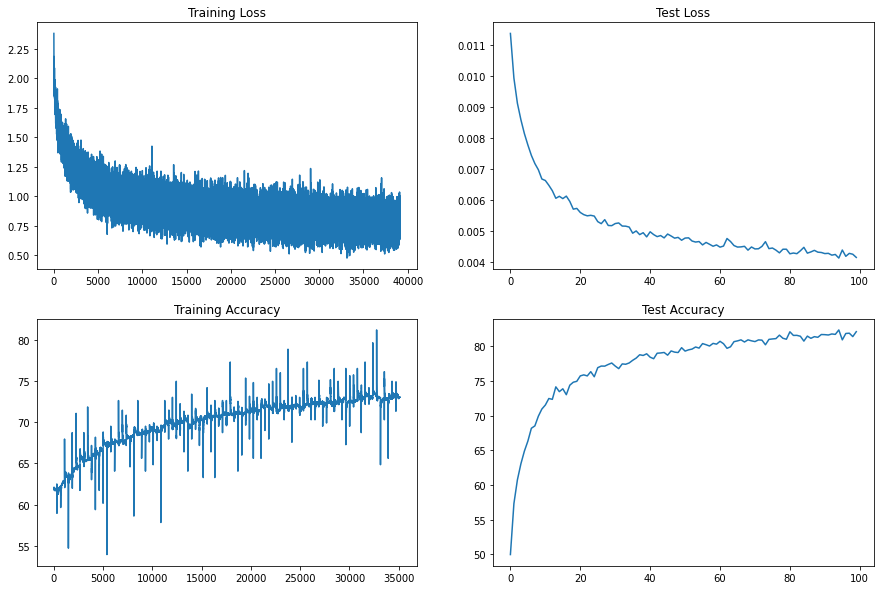

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")